In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt

import cv2
from PIL import Image

from pathlib import Path
from loguru import logger

from src import resize_image, replace_area
from src import WindowInMoment, WindowsContainer
from src import ImageCVHandler, ImagePILHandler, MaskHandler, \
    BorderHandler, PerspectiveHandler

In [2]:
class MaskHandler:
    
    lower_green = (40, 100,  40)
    upper_green = (80, 255, 255)
    
    @classmethod
    def select_green_zone(cls, image: np.ndarray):
        return cv2.inRange(image, cls.lower_green, cls.upper_green)
    
    
    @classmethod
    def blure_mask(cls, mask: np.ndarray):
        kernel = np.ones((3,3),np.uint8)
        # mask_blure = cv2.GaussianBlur(mask.copy(), (3, 3), 0)
        mask_blure = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask_blure = cv2.morphologyEx(mask_blure, cv2.MORPH_CLOSE, kernel)
        return mask_blure
    
    @classmethod
    def findout_gradient(cls, mask: np.ndarray):
        kernel = np.ones((3,3),np.uint8)
        gradient = cv2.morphologyEx(mask, cv2.MORPH_GRADIENT, kernel)
        return gradient

In [3]:
class WindowsContainer:
    
    def __init__(self, num_windows:int = 2, 
            window: int = 20, gamma: float = 0.4
        ):
        self.window = window
        self.gamma = gamma
        
        self.relative   = { k: [] for k in range(num_windows)}
        self._container = { k: [] for k in range(num_windows)}
        
    def findout_key(self, item2: WindowInMoment):
        distances = []
        for k in self._container:
            if len(self._container[k]) != 0:
                item1 = self._container[k][-1]
                dist = (item1.cX - item2.cX) ** 2 + (item1.cY - item2.cY) ** 2
                distances.append((k, dist))
            else:
                distances.append((k, 0))
            
        distances = sorted(distances, key = lambda x: x[1])
        return distances[0][0]
        
        
    def append_item_simple(self, item2: WindowInMoment):
        key = self.findout_key(item2)
        self._container[key].append(item2)
        return item2
        
    @property
    def get_window_keys(self):
        return list(self._container.keys())
    
    def get_area_values(self, key: int) -> list:
        return [x.area for x in self._container[key]]
    
    def get_perimeter_values(self, key: int) -> list:
        return [x.perimeter for x in self._container[key]]
    
    def get_centroid_values(self, key: int) -> np.array:
        return np.array([[x.cX, x.cY] for x in self._container[key]])
    
    def get_corner_values(self, key: int) -> np.array:
        return np.array([[x.corner_1, x.corner_2, x.corner_3, x.corner_4] 
                         for x in self._container[key]])
    
    
    def adapt_params(self, item: WindowInMoment, key: int, 
                      eps_max: float = 0.02, eps_min: float = 0.01):
        
        perimeters = self.get_perimeter_values(key)
        relative_difference = np.abs(1 -  np.mean(perimeters[-self.window :]) / item.perimeter)
        self.relative[key].append(relative_difference)
        if relative_difference > eps_max:
            return 1, 0.95
        elif eps_min < relative_difference < eps_max:
            return 3, 0.85
        
        return self.window, self.gamma
    
    
    # window: int = 20, gamma: float = 0.4
    def append_item_ema(self, item2: WindowInMoment):
        key = self.findout_key(item2)
        prev_corners = self.get_corner_values(key)
        
        if len(prev_corners):
            window, gamma = self.adapt_params(item2, key)
            corners_ema = prev_corners[-window:, :].mean(axis = 0) * (1 - gamma) + gamma * item2.corners

            new_item = copy.copy(item2)
            new_item.corner_1 = corners_ema[0]
            new_item.corner_2 = corners_ema[1]
            new_item.corner_3 = corners_ema[2]
            new_item.corner_4 = corners_ema[3]

            self._container[key].append(new_item)
            return new_item
        
        self._container[key].append(item2)
        return item2

In [4]:
class Pipeline:
    
    def __init__(self, wcontainer: WindowsContainer):
        self._wcontainer = wcontainer
        
    
    def find_windows_region(self, image: np.array):
        img_hsv = ImageCVHandler.convert_BGR_to_HSV(image)
        
        mask = MaskHandler.select_green_zone(img_hsv)
        gradient = MaskHandler.findout_gradient(mask)
        
        contours = BorderHandler.findout_contours(gradient.copy())
        contours = BorderHandler.filter_contours(contours)
        
        croped_image, windows_borders = BorderHandler.crop_image(image, np.vstack(contours))
        return croped_image, windows_borders
        
    def find_windows_borders(self, image: np.array):
        img_rgb = ImageCVHandler.convert_BGR_to_RGB(image)
        img_rgb = Image.fromarray(img_rgb, mode = 'RGB')
        
        improved_img = ImagePILHandler.improve_image(img_rgb)
        img_hsv = ImageCVHandler.convert_RGB_to_HSV(np.array(improved_img))
        
        mask = MaskHandler.select_green_zone(img_hsv)
        mask = MaskHandler.blure_mask(mask.copy())
        gradient = MaskHandler.findout_gradient(mask)
        
        contours = BorderHandler.findout_contours(gradient.copy())
        contours = BorderHandler.filter_contours(contours )
        polygons = BorderHandler.findout_polygons(contours)
        
        return {
            'mask': mask, 
            'gradient': gradient,
            'contours': contours, 
            'polygons': polygons,
            'improved_img': np.array(improved_img)
        }
    
    
    def save_windows_data(self, windows_data: dict):
        items = []
        for i, (contour, polygon) in enumerate(zip(windows_data['contours'], 
                                                   windows_data['polygons'])):
                
            centroid = BorderHandler.findout_window_centroid(contour)
            geometry = BorderHandler.findout_window_area_perimeter(contour)
            corners  = BorderHandler.findout_corners(polygon, centroid)
            
            item = WindowInMoment(
                geometry['area'], geometry['perimeter'], 
                centroid['cX'], centroid['cY'], *corners            
            )
        
#             item = self._wcontainer.append_item_simple(item)
#             items.append(item)
            
            updated_item = self._wcontainer.append_item_ema(item)
            items.append(updated_item)
        
        return items
    
    
    def write_video(self, video_path, output_path, resume_image):
        video = cv2.VideoCapture(video_path)

        fps = video.get(cv2.CAP_PROP_FPS)
        frame_w = int(video.get(cv2.CAP_PROP_FRAME_WIDTH ))
        frame_h = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        output = cv2.VideoWriter(output_path, fourcc, fps, (frame_w, frame_h))
        frame_num = 0
        
        while True:
            frame_num += 1
            ret, frame = video.read()

            if not ret:
                break
            
            # select active zone
            croped_image, windows_borders = self.find_windows_region(frame.copy())
            croped_image = resize_image(croped_image.copy(), 2)
        
            windows_data = self.find_windows_borders(croped_image.copy())
            zoomed_image = cv2.bitwise_and(windows_data['improved_img'], 
                                           windows_data['improved_img'], mask=~windows_data['gradient'])
            # plot corners
            for polygon in windows_data['polygons']:
                polygon = polygon.reshape(polygon.shape[0], -1)
                
                for point in polygon:
                    zoomed_image = cv2.circle(zoomed_image, point, radius=3, 
                                           color=(0, 0, 255), thickness=-1)
            
            # make perspective transformations
            new_croped_image = croped_image.copy()
            for item in self.save_windows_data(windows_data):
                rotated_image = PerspectiveHandler.transform(resume_image, 
                                            croped_image, item.corners)
                
                new_croped_image = PerspectiveHandler.replace_by_mask(rotated_image, new_croped_image)
            
            # invert resize
            new_croped_image = resize_image(new_croped_image.copy(), 0.5)
            new_frame = replace_area(frame.copy(), new_croped_image, windows_borders)
                     
            logger.info(f'Frame Num: {frame_num}')
            output.write(new_frame)
            if cv2.waitKey(1) == 27:
                break

        video.release()
        output.release()
        cv2.destroyAllWindows()
        
        
    def write_mask(self, video_path, output_path, resume_image):
        video = cv2.VideoCapture(video_path)

        fps = video.get(cv2.CAP_PROP_FPS)
        frame_w = int(video.get(cv2.CAP_PROP_FRAME_WIDTH ))
        frame_h = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        output = cv2.VideoWriter(output_path, fourcc, fps, (frame_w, frame_h))
        frame_num = 0
        
        while True:
            frame_num += 1
            ret, frame = video.read()

            if not ret:
                break
            
            # select active zone of image
            croped_image, windows_borders = self.find_windows_region(frame.copy())
            croped_image = resize_image(croped_image.copy(), 2)
        
            windows_data = self.find_windows_borders(croped_image.copy())
            zoomed_image = cv2.bitwise_and(windows_data['improved_img'], 
                                           windows_data['improved_img'], mask=~windows_data['gradient'])
            # plot corners
            for polygon in windows_data['polygons']:
                polygon = polygon.reshape(polygon.shape[0], -1)
                
                for point in polygon:
                    zoomed_image = cv2.circle(zoomed_image, point, radius=3, 
                                           color=(0, 0, 255), thickness=-1)
    
            # add zoomed_image to original image
            step = 200
            replace_coord = {
                'w': [step, zoomed_image.shape[0] + step], 
                'h': [step, zoomed_image.shape[1] + step]
            }        
            
            new_frame = replace_area(frame, zoomed_image, replace_coord)            
            logger.info(f'Frame Num: {frame_num}')
            
            output.write(new_frame)
            if cv2.waitKey(1) == 27:
                break

        video.release()
        output.release()
        cv2.destroyAllWindows()

In [5]:
# # zoomed version
# resume_image = ImageCVHandler.load_image('./data', 'resume_img.png')


# container = WindowsContainer(**{
#     'num_windows': 2,
#     'window': 7, 'gamma': 0.6
# })


# pipeline = Pipeline(container)
# pipeline.write_mask('data/input_video.mp4', 
#                      'data/mask_video.mp4', resume_image)

In [6]:
# Usage:
resume_image = ImageCVHandler.load_image('./data', 'resume_img.png')


container = WindowsContainer(**{
    'num_windows': 2,
    'window': 7, 'gamma': 0.6
})



pipeline = Pipeline(container)
pipeline.write_video('data/input_video.mp4', 
                     'data/output_video.mp4', resume_image)

2023-06-20 16:03:57.910 | INFO     | __main__:write_video:111 - Frame Num: 1
2023-06-20 16:03:58.148 | INFO     | __main__:write_video:111 - Frame Num: 2
2023-06-20 16:03:58.374 | INFO     | __main__:write_video:111 - Frame Num: 3
2023-06-20 16:03:58.601 | INFO     | __main__:write_video:111 - Frame Num: 4
2023-06-20 16:03:58.825 | INFO     | __main__:write_video:111 - Frame Num: 5
2023-06-20 16:03:59.041 | INFO     | __main__:write_video:111 - Frame Num: 6
2023-06-20 16:03:59.270 | INFO     | __main__:write_video:111 - Frame Num: 7
2023-06-20 16:03:59.491 | INFO     | __main__:write_video:111 - Frame Num: 8
2023-06-20 16:03:59.716 | INFO     | __main__:write_video:111 - Frame Num: 9
2023-06-20 16:03:59.948 | INFO     | __main__:write_video:111 - Frame Num: 10
2023-06-20 16:04:00.175 | INFO     | __main__:write_video:111 - Frame Num: 11
2023-06-20 16:04:00.420 | INFO     | __main__:write_video:111 - Frame Num: 12
2023-06-20 16:04:00.643 | INFO     | __main__:write_video:111 - Frame Num

2023-06-20 16:04:12.561 | INFO     | __main__:write_video:111 - Frame Num: 65
2023-06-20 16:04:12.784 | INFO     | __main__:write_video:111 - Frame Num: 66
2023-06-20 16:04:13.017 | INFO     | __main__:write_video:111 - Frame Num: 67
2023-06-20 16:04:13.246 | INFO     | __main__:write_video:111 - Frame Num: 68
2023-06-20 16:04:13.475 | INFO     | __main__:write_video:111 - Frame Num: 69
2023-06-20 16:04:13.704 | INFO     | __main__:write_video:111 - Frame Num: 70
2023-06-20 16:04:13.918 | INFO     | __main__:write_video:111 - Frame Num: 71
2023-06-20 16:04:14.144 | INFO     | __main__:write_video:111 - Frame Num: 72
2023-06-20 16:04:14.365 | INFO     | __main__:write_video:111 - Frame Num: 73
2023-06-20 16:04:14.586 | INFO     | __main__:write_video:111 - Frame Num: 74
2023-06-20 16:04:14.802 | INFO     | __main__:write_video:111 - Frame Num: 75
2023-06-20 16:04:15.027 | INFO     | __main__:write_video:111 - Frame Num: 76
2023-06-20 16:04:15.254 | INFO     | __main__:write_video:111 - 

2023-06-20 16:04:26.788 | INFO     | __main__:write_video:111 - Frame Num: 128
2023-06-20 16:04:26.994 | INFO     | __main__:write_video:111 - Frame Num: 129
2023-06-20 16:04:27.197 | INFO     | __main__:write_video:111 - Frame Num: 130
2023-06-20 16:04:27.420 | INFO     | __main__:write_video:111 - Frame Num: 131
2023-06-20 16:04:27.621 | INFO     | __main__:write_video:111 - Frame Num: 132
2023-06-20 16:04:27.887 | INFO     | __main__:write_video:111 - Frame Num: 133
2023-06-20 16:04:28.209 | INFO     | __main__:write_video:111 - Frame Num: 134
2023-06-20 16:04:28.458 | INFO     | __main__:write_video:111 - Frame Num: 135
2023-06-20 16:04:28.693 | INFO     | __main__:write_video:111 - Frame Num: 136
2023-06-20 16:04:28.896 | INFO     | __main__:write_video:111 - Frame Num: 137
2023-06-20 16:04:29.134 | INFO     | __main__:write_video:111 - Frame Num: 138
2023-06-20 16:04:29.357 | INFO     | __main__:write_video:111 - Frame Num: 139
2023-06-20 16:04:29.577 | INFO     | __main__:write_

2023-06-20 16:04:41.300 | INFO     | __main__:write_video:111 - Frame Num: 191
2023-06-20 16:04:41.549 | INFO     | __main__:write_video:111 - Frame Num: 192
2023-06-20 16:04:41.787 | INFO     | __main__:write_video:111 - Frame Num: 193
2023-06-20 16:04:42.086 | INFO     | __main__:write_video:111 - Frame Num: 194
2023-06-20 16:04:42.359 | INFO     | __main__:write_video:111 - Frame Num: 195
2023-06-20 16:04:42.573 | INFO     | __main__:write_video:111 - Frame Num: 196
2023-06-20 16:04:42.854 | INFO     | __main__:write_video:111 - Frame Num: 197
2023-06-20 16:04:43.095 | INFO     | __main__:write_video:111 - Frame Num: 198
2023-06-20 16:04:43.315 | INFO     | __main__:write_video:111 - Frame Num: 199
2023-06-20 16:04:43.609 | INFO     | __main__:write_video:111 - Frame Num: 200
2023-06-20 16:04:43.822 | INFO     | __main__:write_video:111 - Frame Num: 201
2023-06-20 16:04:44.062 | INFO     | __main__:write_video:111 - Frame Num: 202
2023-06-20 16:04:44.276 | INFO     | __main__:write_

2023-06-20 16:04:55.880 | INFO     | __main__:write_video:111 - Frame Num: 254
2023-06-20 16:04:56.087 | INFO     | __main__:write_video:111 - Frame Num: 255
2023-06-20 16:04:56.336 | INFO     | __main__:write_video:111 - Frame Num: 256
2023-06-20 16:04:56.562 | INFO     | __main__:write_video:111 - Frame Num: 257
2023-06-20 16:04:56.762 | INFO     | __main__:write_video:111 - Frame Num: 258
2023-06-20 16:04:56.964 | INFO     | __main__:write_video:111 - Frame Num: 259
2023-06-20 16:04:57.172 | INFO     | __main__:write_video:111 - Frame Num: 260
2023-06-20 16:04:57.377 | INFO     | __main__:write_video:111 - Frame Num: 261
2023-06-20 16:04:57.639 | INFO     | __main__:write_video:111 - Frame Num: 262
2023-06-20 16:04:57.880 | INFO     | __main__:write_video:111 - Frame Num: 263
2023-06-20 16:04:58.130 | INFO     | __main__:write_video:111 - Frame Num: 264
2023-06-20 16:04:58.333 | INFO     | __main__:write_video:111 - Frame Num: 265
2023-06-20 16:04:58.547 | INFO     | __main__:write_

2023-06-20 16:05:09.825 | INFO     | __main__:write_video:111 - Frame Num: 317
2023-06-20 16:05:10.104 | INFO     | __main__:write_video:111 - Frame Num: 318
2023-06-20 16:05:10.314 | INFO     | __main__:write_video:111 - Frame Num: 319
2023-06-20 16:05:10.512 | INFO     | __main__:write_video:111 - Frame Num: 320
2023-06-20 16:05:10.767 | INFO     | __main__:write_video:111 - Frame Num: 321
2023-06-20 16:05:10.966 | INFO     | __main__:write_video:111 - Frame Num: 322
2023-06-20 16:05:11.182 | INFO     | __main__:write_video:111 - Frame Num: 323
2023-06-20 16:05:11.375 | INFO     | __main__:write_video:111 - Frame Num: 324
2023-06-20 16:05:11.575 | INFO     | __main__:write_video:111 - Frame Num: 325
2023-06-20 16:05:11.776 | INFO     | __main__:write_video:111 - Frame Num: 326
2023-06-20 16:05:12.022 | INFO     | __main__:write_video:111 - Frame Num: 327
2023-06-20 16:05:12.227 | INFO     | __main__:write_video:111 - Frame Num: 328
2023-06-20 16:05:12.427 | INFO     | __main__:write_

2023-06-20 16:05:23.794 | INFO     | __main__:write_video:111 - Frame Num: 380
2023-06-20 16:05:24.004 | INFO     | __main__:write_video:111 - Frame Num: 381
2023-06-20 16:05:24.209 | INFO     | __main__:write_video:111 - Frame Num: 382
2023-06-20 16:05:24.461 | INFO     | __main__:write_video:111 - Frame Num: 383
2023-06-20 16:05:24.669 | INFO     | __main__:write_video:111 - Frame Num: 384
2023-06-20 16:05:24.877 | INFO     | __main__:write_video:111 - Frame Num: 385
2023-06-20 16:05:25.101 | INFO     | __main__:write_video:111 - Frame Num: 386
2023-06-20 16:05:25.377 | INFO     | __main__:write_video:111 - Frame Num: 387
2023-06-20 16:05:25.645 | INFO     | __main__:write_video:111 - Frame Num: 388
2023-06-20 16:05:25.864 | INFO     | __main__:write_video:111 - Frame Num: 389
2023-06-20 16:05:26.112 | INFO     | __main__:write_video:111 - Frame Num: 390
2023-06-20 16:05:26.347 | INFO     | __main__:write_video:111 - Frame Num: 391
2023-06-20 16:05:26.591 | INFO     | __main__:write_

2023-06-20 16:05:38.065 | INFO     | __main__:write_video:111 - Frame Num: 443
2023-06-20 16:05:38.273 | INFO     | __main__:write_video:111 - Frame Num: 444
2023-06-20 16:05:38.482 | INFO     | __main__:write_video:111 - Frame Num: 445
2023-06-20 16:05:38.742 | INFO     | __main__:write_video:111 - Frame Num: 446
2023-06-20 16:05:38.957 | INFO     | __main__:write_video:111 - Frame Num: 447
2023-06-20 16:05:39.209 | INFO     | __main__:write_video:111 - Frame Num: 448
2023-06-20 16:05:39.422 | INFO     | __main__:write_video:111 - Frame Num: 449
2023-06-20 16:05:39.631 | INFO     | __main__:write_video:111 - Frame Num: 450
2023-06-20 16:05:39.836 | INFO     | __main__:write_video:111 - Frame Num: 451
2023-06-20 16:05:40.054 | INFO     | __main__:write_video:111 - Frame Num: 452
2023-06-20 16:05:40.262 | INFO     | __main__:write_video:111 - Frame Num: 453
2023-06-20 16:05:40.463 | INFO     | __main__:write_video:111 - Frame Num: 454
2023-06-20 16:05:40.681 | INFO     | __main__:write_

2023-06-20 16:05:53.216 | INFO     | __main__:write_video:111 - Frame Num: 506
2023-06-20 16:05:53.427 | INFO     | __main__:write_video:111 - Frame Num: 507
2023-06-20 16:05:53.649 | INFO     | __main__:write_video:111 - Frame Num: 508
2023-06-20 16:05:53.882 | INFO     | __main__:write_video:111 - Frame Num: 509
2023-06-20 16:05:54.106 | INFO     | __main__:write_video:111 - Frame Num: 510
2023-06-20 16:05:54.315 | INFO     | __main__:write_video:111 - Frame Num: 511
2023-06-20 16:05:54.530 | INFO     | __main__:write_video:111 - Frame Num: 512
2023-06-20 16:05:54.769 | INFO     | __main__:write_video:111 - Frame Num: 513
2023-06-20 16:05:55.042 | INFO     | __main__:write_video:111 - Frame Num: 514
2023-06-20 16:05:55.262 | INFO     | __main__:write_video:111 - Frame Num: 515
2023-06-20 16:05:55.497 | INFO     | __main__:write_video:111 - Frame Num: 516
2023-06-20 16:05:55.710 | INFO     | __main__:write_video:111 - Frame Num: 517
2023-06-20 16:05:55.981 | INFO     | __main__:write_

2023-06-20 16:06:07.057 | INFO     | __main__:write_video:111 - Frame Num: 569
2023-06-20 16:06:07.267 | INFO     | __main__:write_video:111 - Frame Num: 570
2023-06-20 16:06:07.496 | INFO     | __main__:write_video:111 - Frame Num: 571
2023-06-20 16:06:07.726 | INFO     | __main__:write_video:111 - Frame Num: 572
2023-06-20 16:06:07.943 | INFO     | __main__:write_video:111 - Frame Num: 573
2023-06-20 16:06:08.164 | INFO     | __main__:write_video:111 - Frame Num: 574
2023-06-20 16:06:08.390 | INFO     | __main__:write_video:111 - Frame Num: 575
2023-06-20 16:06:08.616 | INFO     | __main__:write_video:111 - Frame Num: 576
2023-06-20 16:06:08.838 | INFO     | __main__:write_video:111 - Frame Num: 577
2023-06-20 16:06:09.049 | INFO     | __main__:write_video:111 - Frame Num: 578
2023-06-20 16:06:09.278 | INFO     | __main__:write_video:111 - Frame Num: 579
2023-06-20 16:06:09.491 | INFO     | __main__:write_video:111 - Frame Num: 580
2023-06-20 16:06:09.706 | INFO     | __main__:write_

2023-06-20 16:06:20.745 | INFO     | __main__:write_video:111 - Frame Num: 632
2023-06-20 16:06:20.954 | INFO     | __main__:write_video:111 - Frame Num: 633
2023-06-20 16:06:21.176 | INFO     | __main__:write_video:111 - Frame Num: 634
2023-06-20 16:06:21.395 | INFO     | __main__:write_video:111 - Frame Num: 635
2023-06-20 16:06:21.615 | INFO     | __main__:write_video:111 - Frame Num: 636
2023-06-20 16:06:21.825 | INFO     | __main__:write_video:111 - Frame Num: 637
2023-06-20 16:06:22.051 | INFO     | __main__:write_video:111 - Frame Num: 638
2023-06-20 16:06:22.272 | INFO     | __main__:write_video:111 - Frame Num: 639
2023-06-20 16:06:22.495 | INFO     | __main__:write_video:111 - Frame Num: 640
2023-06-20 16:06:22.708 | INFO     | __main__:write_video:111 - Frame Num: 641
2023-06-20 16:06:22.928 | INFO     | __main__:write_video:111 - Frame Num: 642
2023-06-20 16:06:23.139 | INFO     | __main__:write_video:111 - Frame Num: 643
2023-06-20 16:06:23.404 | INFO     | __main__:write_

2023-06-20 16:06:36.722 | INFO     | __main__:write_video:111 - Frame Num: 695
2023-06-20 16:06:37.074 | INFO     | __main__:write_video:111 - Frame Num: 696
2023-06-20 16:06:37.432 | INFO     | __main__:write_video:111 - Frame Num: 697
2023-06-20 16:06:37.794 | INFO     | __main__:write_video:111 - Frame Num: 698
2023-06-20 16:06:38.161 | INFO     | __main__:write_video:111 - Frame Num: 699
2023-06-20 16:06:38.514 | INFO     | __main__:write_video:111 - Frame Num: 700
2023-06-20 16:06:38.861 | INFO     | __main__:write_video:111 - Frame Num: 701
2023-06-20 16:06:39.191 | INFO     | __main__:write_video:111 - Frame Num: 702
2023-06-20 16:06:39.530 | INFO     | __main__:write_video:111 - Frame Num: 703
2023-06-20 16:06:39.867 | INFO     | __main__:write_video:111 - Frame Num: 704
2023-06-20 16:06:40.186 | INFO     | __main__:write_video:111 - Frame Num: 705
2023-06-20 16:06:40.500 | INFO     | __main__:write_video:111 - Frame Num: 706
2023-06-20 16:06:40.824 | INFO     | __main__:write_

2023-06-20 16:06:54.603 | INFO     | __main__:write_video:111 - Frame Num: 758
2023-06-20 16:06:54.857 | INFO     | __main__:write_video:111 - Frame Num: 759
2023-06-20 16:06:55.119 | INFO     | __main__:write_video:111 - Frame Num: 760
2023-06-20 16:06:55.381 | INFO     | __main__:write_video:111 - Frame Num: 761
2023-06-20 16:06:55.645 | INFO     | __main__:write_video:111 - Frame Num: 762
2023-06-20 16:06:55.897 | INFO     | __main__:write_video:111 - Frame Num: 763
2023-06-20 16:06:56.155 | INFO     | __main__:write_video:111 - Frame Num: 764
2023-06-20 16:06:56.413 | INFO     | __main__:write_video:111 - Frame Num: 765
2023-06-20 16:06:56.664 | INFO     | __main__:write_video:111 - Frame Num: 766
2023-06-20 16:06:56.941 | INFO     | __main__:write_video:111 - Frame Num: 767
2023-06-20 16:06:57.196 | INFO     | __main__:write_video:111 - Frame Num: 768
2023-06-20 16:06:57.462 | INFO     | __main__:write_video:111 - Frame Num: 769
2023-06-20 16:06:57.712 | INFO     | __main__:write_

2023-06-20 16:07:10.813 | INFO     | __main__:write_video:111 - Frame Num: 821
2023-06-20 16:07:11.058 | INFO     | __main__:write_video:111 - Frame Num: 822
2023-06-20 16:07:11.319 | INFO     | __main__:write_video:111 - Frame Num: 823
2023-06-20 16:07:11.573 | INFO     | __main__:write_video:111 - Frame Num: 824
2023-06-20 16:07:11.828 | INFO     | __main__:write_video:111 - Frame Num: 825
2023-06-20 16:07:12.084 | INFO     | __main__:write_video:111 - Frame Num: 826
2023-06-20 16:07:12.332 | INFO     | __main__:write_video:111 - Frame Num: 827
2023-06-20 16:07:12.589 | INFO     | __main__:write_video:111 - Frame Num: 828
2023-06-20 16:07:12.841 | INFO     | __main__:write_video:111 - Frame Num: 829
2023-06-20 16:07:13.090 | INFO     | __main__:write_video:111 - Frame Num: 830
2023-06-20 16:07:13.346 | INFO     | __main__:write_video:111 - Frame Num: 831
2023-06-20 16:07:13.597 | INFO     | __main__:write_video:111 - Frame Num: 832
2023-06-20 16:07:13.844 | INFO     | __main__:write_

2023-06-20 16:07:26.711 | INFO     | __main__:write_video:111 - Frame Num: 884
2023-06-20 16:07:26.956 | INFO     | __main__:write_video:111 - Frame Num: 885
2023-06-20 16:07:27.218 | INFO     | __main__:write_video:111 - Frame Num: 886
2023-06-20 16:07:27.458 | INFO     | __main__:write_video:111 - Frame Num: 887
2023-06-20 16:07:27.735 | INFO     | __main__:write_video:111 - Frame Num: 888
2023-06-20 16:07:28.015 | INFO     | __main__:write_video:111 - Frame Num: 889
2023-06-20 16:07:28.261 | INFO     | __main__:write_video:111 - Frame Num: 890
2023-06-20 16:07:28.498 | INFO     | __main__:write_video:111 - Frame Num: 891
2023-06-20 16:07:28.733 | INFO     | __main__:write_video:111 - Frame Num: 892
2023-06-20 16:07:28.966 | INFO     | __main__:write_video:111 - Frame Num: 893
2023-06-20 16:07:29.272 | INFO     | __main__:write_video:111 - Frame Num: 894
2023-06-20 16:07:29.550 | INFO     | __main__:write_video:111 - Frame Num: 895
2023-06-20 16:07:29.795 | INFO     | __main__:write_

2023-06-20 16:07:42.814 | INFO     | __main__:write_video:111 - Frame Num: 947
2023-06-20 16:07:43.044 | INFO     | __main__:write_video:111 - Frame Num: 948
2023-06-20 16:07:43.261 | INFO     | __main__:write_video:111 - Frame Num: 949
2023-06-20 16:07:43.483 | INFO     | __main__:write_video:111 - Frame Num: 950
2023-06-20 16:07:43.705 | INFO     | __main__:write_video:111 - Frame Num: 951
2023-06-20 16:07:43.930 | INFO     | __main__:write_video:111 - Frame Num: 952
2023-06-20 16:07:44.196 | INFO     | __main__:write_video:111 - Frame Num: 953
2023-06-20 16:07:44.433 | INFO     | __main__:write_video:111 - Frame Num: 954
2023-06-20 16:07:44.659 | INFO     | __main__:write_video:111 - Frame Num: 955
2023-06-20 16:07:44.933 | INFO     | __main__:write_video:111 - Frame Num: 956
2023-06-20 16:07:45.173 | INFO     | __main__:write_video:111 - Frame Num: 957
2023-06-20 16:07:45.399 | INFO     | __main__:write_video:111 - Frame Num: 958
2023-06-20 16:07:45.622 | INFO     | __main__:write_

2023-06-20 16:07:58.068 | INFO     | __main__:write_video:111 - Frame Num: 1010
2023-06-20 16:07:58.290 | INFO     | __main__:write_video:111 - Frame Num: 1011
2023-06-20 16:07:58.521 | INFO     | __main__:write_video:111 - Frame Num: 1012
2023-06-20 16:07:58.747 | INFO     | __main__:write_video:111 - Frame Num: 1013
2023-06-20 16:07:59.023 | INFO     | __main__:write_video:111 - Frame Num: 1014
2023-06-20 16:07:59.250 | INFO     | __main__:write_video:111 - Frame Num: 1015
2023-06-20 16:07:59.566 | INFO     | __main__:write_video:111 - Frame Num: 1016
2023-06-20 16:07:59.791 | INFO     | __main__:write_video:111 - Frame Num: 1017
2023-06-20 16:08:00.022 | INFO     | __main__:write_video:111 - Frame Num: 1018
2023-06-20 16:08:00.253 | INFO     | __main__:write_video:111 - Frame Num: 1019
2023-06-20 16:08:00.477 | INFO     | __main__:write_video:111 - Frame Num: 1020
2023-06-20 16:08:00.703 | INFO     | __main__:write_video:111 - Frame Num: 1021
2023-06-20 16:08:00.927 | INFO     | __m

2023-06-20 16:08:13.362 | INFO     | __main__:write_video:111 - Frame Num: 1073
2023-06-20 16:08:13.623 | INFO     | __main__:write_video:111 - Frame Num: 1074
2023-06-20 16:08:13.850 | INFO     | __main__:write_video:111 - Frame Num: 1075
2023-06-20 16:08:14.076 | INFO     | __main__:write_video:111 - Frame Num: 1076
2023-06-20 16:08:14.325 | INFO     | __main__:write_video:111 - Frame Num: 1077
2023-06-20 16:08:14.567 | INFO     | __main__:write_video:111 - Frame Num: 1078
2023-06-20 16:08:14.796 | INFO     | __main__:write_video:111 - Frame Num: 1079
2023-06-20 16:08:15.029 | INFO     | __main__:write_video:111 - Frame Num: 1080
2023-06-20 16:08:15.264 | INFO     | __main__:write_video:111 - Frame Num: 1081
2023-06-20 16:08:15.517 | INFO     | __main__:write_video:111 - Frame Num: 1082
2023-06-20 16:08:15.754 | INFO     | __main__:write_video:111 - Frame Num: 1083
2023-06-20 16:08:15.988 | INFO     | __main__:write_video:111 - Frame Num: 1084
2023-06-20 16:08:16.223 | INFO     | __m

2023-06-20 16:08:31.098 | INFO     | __main__:write_video:111 - Frame Num: 1136
2023-06-20 16:08:31.411 | INFO     | __main__:write_video:111 - Frame Num: 1137
2023-06-20 16:08:31.728 | INFO     | __main__:write_video:111 - Frame Num: 1138
2023-06-20 16:08:32.026 | INFO     | __main__:write_video:111 - Frame Num: 1139
2023-06-20 16:08:32.345 | INFO     | __main__:write_video:111 - Frame Num: 1140
2023-06-20 16:08:32.654 | INFO     | __main__:write_video:111 - Frame Num: 1141
2023-06-20 16:08:32.978 | INFO     | __main__:write_video:111 - Frame Num: 1142
2023-06-20 16:08:33.314 | INFO     | __main__:write_video:111 - Frame Num: 1143
2023-06-20 16:08:33.649 | INFO     | __main__:write_video:111 - Frame Num: 1144
2023-06-20 16:08:33.990 | INFO     | __main__:write_video:111 - Frame Num: 1145
2023-06-20 16:08:34.336 | INFO     | __main__:write_video:111 - Frame Num: 1146
2023-06-20 16:08:34.709 | INFO     | __main__:write_video:111 - Frame Num: 1147
2023-06-20 16:08:35.070 | INFO     | __m

2023-06-20 16:09:01.097 | INFO     | __main__:write_video:111 - Frame Num: 1199
2023-06-20 16:09:01.892 | INFO     | __main__:write_video:111 - Frame Num: 1200
2023-06-20 16:09:02.555 | INFO     | __main__:write_video:111 - Frame Num: 1201
2023-06-20 16:09:03.251 | INFO     | __main__:write_video:111 - Frame Num: 1202
2023-06-20 16:09:04.012 | INFO     | __main__:write_video:111 - Frame Num: 1203
2023-06-20 16:09:04.716 | INFO     | __main__:write_video:111 - Frame Num: 1204
2023-06-20 16:09:05.431 | INFO     | __main__:write_video:111 - Frame Num: 1205
2023-06-20 16:09:06.146 | INFO     | __main__:write_video:111 - Frame Num: 1206
2023-06-20 16:09:06.849 | INFO     | __main__:write_video:111 - Frame Num: 1207
2023-06-20 16:09:07.562 | INFO     | __main__:write_video:111 - Frame Num: 1208
2023-06-20 16:09:08.329 | INFO     | __main__:write_video:111 - Frame Num: 1209
2023-06-20 16:09:09.030 | INFO     | __main__:write_video:111 - Frame Num: 1210
2023-06-20 16:09:09.741 | INFO     | __m

2023-06-20 16:09:53.520 | INFO     | __main__:write_video:111 - Frame Num: 1262
2023-06-20 16:09:54.542 | INFO     | __main__:write_video:111 - Frame Num: 1263
2023-06-20 16:09:55.663 | INFO     | __main__:write_video:111 - Frame Num: 1264
2023-06-20 16:09:56.888 | INFO     | __main__:write_video:111 - Frame Num: 1265
2023-06-20 16:09:58.217 | INFO     | __main__:write_video:111 - Frame Num: 1266
2023-06-20 16:09:59.000 | INFO     | __main__:write_video:111 - Frame Num: 1267
2023-06-20 16:09:59.805 | INFO     | __main__:write_video:111 - Frame Num: 1268
2023-06-20 16:10:00.566 | INFO     | __main__:write_video:111 - Frame Num: 1269
2023-06-20 16:10:01.382 | INFO     | __main__:write_video:111 - Frame Num: 1270
2023-06-20 16:10:02.221 | INFO     | __main__:write_video:111 - Frame Num: 1271
2023-06-20 16:10:03.069 | INFO     | __main__:write_video:111 - Frame Num: 1272
2023-06-20 16:10:03.901 | INFO     | __main__:write_video:111 - Frame Num: 1273
2023-06-20 16:10:04.728 | INFO     | __m

In [7]:
wcontn = pipeline._wcontainer
keys = wcontn.get_window_keys
keys

[0, 1]

In [8]:
frame_indexes = np.arange(len(wcontn.get_area_values(keys[0])))
sindex, eindex = np.min(frame_indexes), np.max(frame_indexes)
sindex, eindex

(0, 1302)

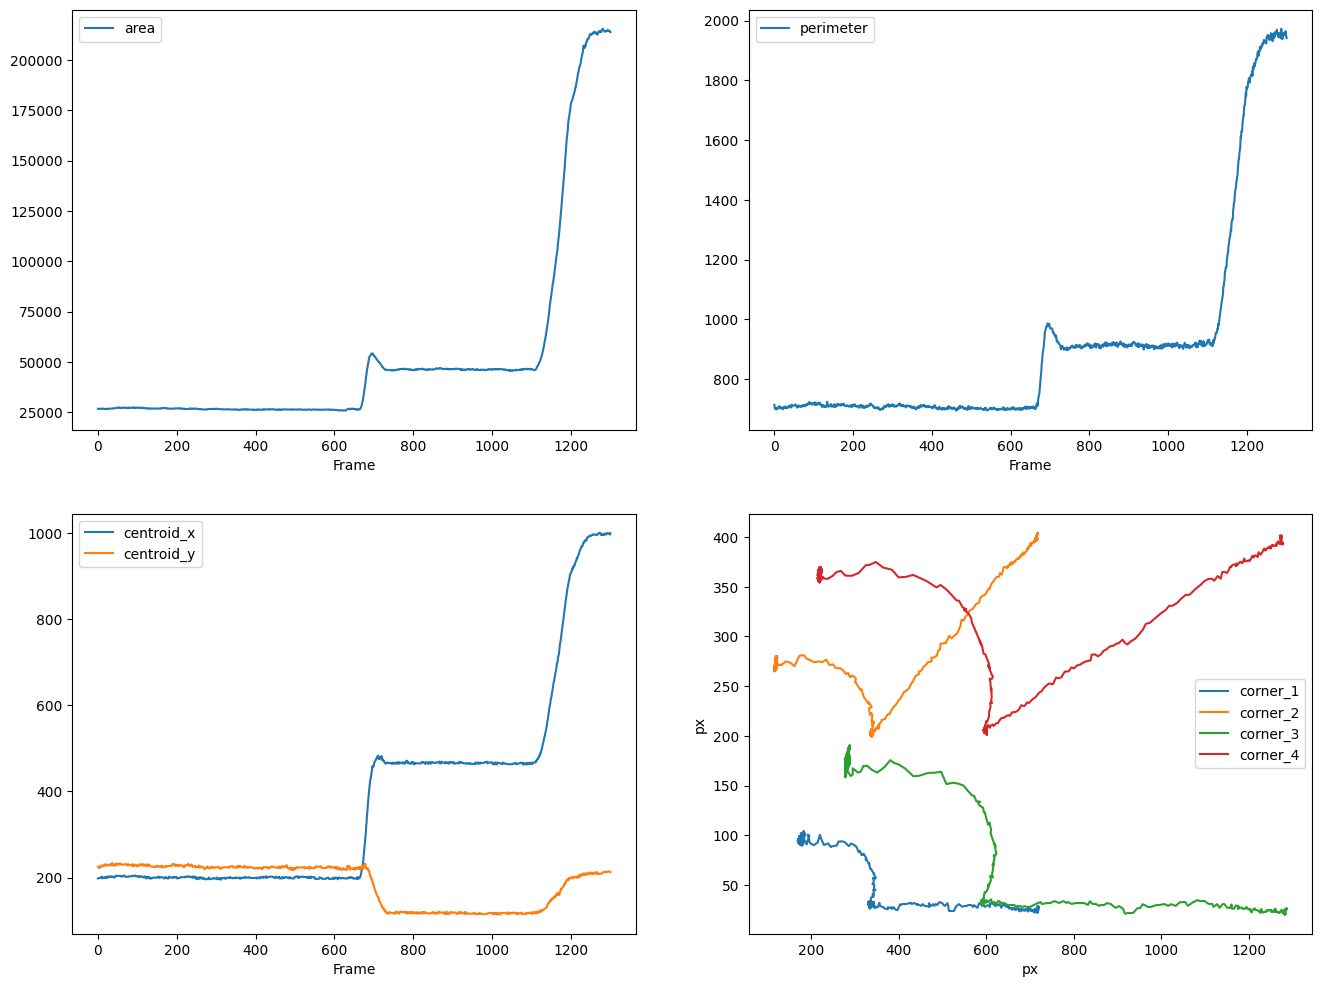

In [9]:
KEY = 0
fig, axes = plt.subplots(2, 2, figsize = (16, 12))

axes[0, 0].plot(frame_indexes[sindex:eindex], wcontn.get_area_values(KEY)[sindex:eindex], label='area')
axes[0, 1].plot(frame_indexes[sindex:eindex], wcontn.get_perimeter_values(KEY)[sindex:eindex], label='perimeter')


centroids = wcontn.get_centroid_values(KEY)
axes[1, 0].plot(frame_indexes[sindex:eindex], centroids[sindex:eindex, 0], label='centroid_x')
axes[1, 0].plot(frame_indexes[sindex:eindex], centroids[sindex:eindex, 1], label='centroid_y')

corners = wcontn.get_corner_values(KEY)
for i in range(4):
    axes[1, 1].plot(corners[sindex:eindex, i, 0], 
                    corners[sindex:eindex, i, 1], label=f'corner_{i+1}')
    
for i in range(2):
    for j in range(2):
        axes[i, j].set_xlabel('Frame')
        axes[i, j].legend()

axes[1, 1].set_xlabel('px')
axes[1, 1].set_ylabel('px')

plt.show()

In [10]:
sindex, eindex = 0, 600
corners[sindex:eindex, :, :].std(axis = 0)

array([[3.1345853 , 2.32303404],
       [1.24407097, 3.18513396],
       [2.61443727, 5.13844046],
       [1.77844518, 2.93715979]])

In [11]:
sindex, eindex = 800, 1050
corners[sindex:eindex, :, :].std(axis = 0)

array([[1.43478   , 1.28247017],
       [1.15966479, 1.19012085],
       [1.55443927, 1.29562208],
       [1.49733489, 1.38518802]])

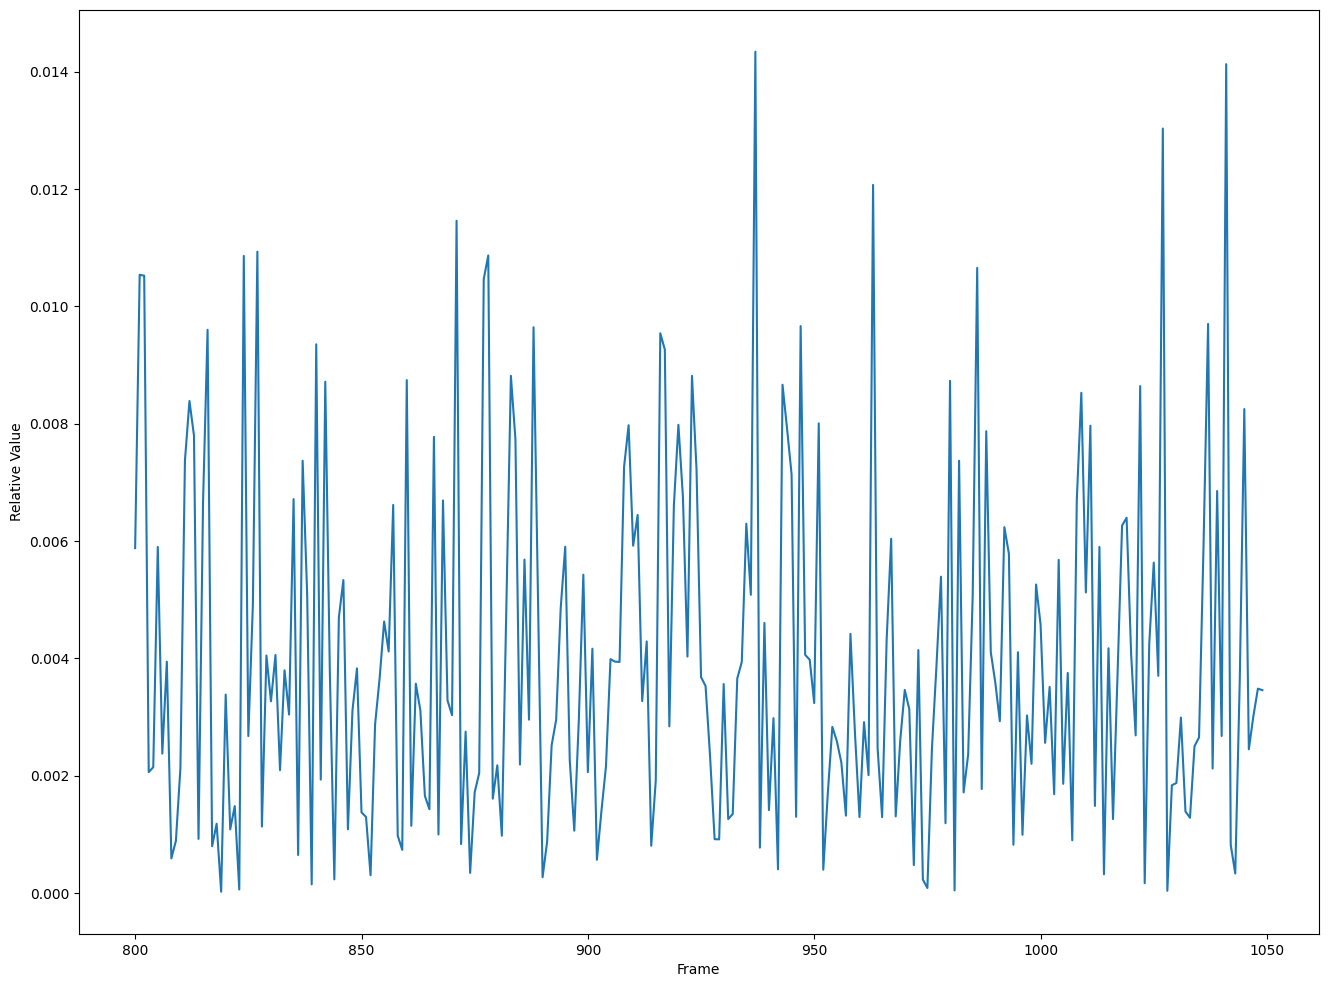

In [12]:
sindex, eindex = 800, 1050
fig, ax = plt.subplots(1, 1, figsize = (16, 12))
ax.plot(frame_indexes[sindex:eindex], wcontn.relative[KEY][sindex:eindex])
ax.set_xlabel('Frame')
ax.set_ylabel('Relative Value')

plt.show()